# Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import datetime
import time as t
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(style="white", context="talk")
import os
os.chdir('DIRECTORY/DIRECTORY/...')

# Data Gathering

In [3]:
# For any URL, return the JSON
def return_json(URL, session):
    while True:
        response = session.get(URL)
        try:
            # Check for 404 error and quit if received
            if response.json()['status']['status_code'] == 404:
                return "error - status code 404"
            # Check for 429 (too many requests made), sleep if received
            elif response.json()['status']['status_code'] == 429:
                t.sleep(10)
                continue
            else:
                return "error - unknown reason"
        except:
            break
    return response.json()

# Provide the match-id & region, receive the json of match timeline (1 minute interval of match data)
def get_matchTimeline(matchId, region, key, session):
    URL = 'https://' + region + '.api.riotgames.com/lol/match/v4/timelines/by-match/' + str(
        matchId) + '/?api_key=' + key
    json = return_json(URL, session)
    return json


# Provide the match-id & region, receive the match information (game length, participants etc..)
def get_gameInfo(matchId, region, key, session):
    URL = 'https://' + region + '.api.riotgames.com/lol/match/v4/matches/' + str(matchId) + '/?api_key=' + key
    json = return_json(URL, session)
    return json

def set_volume(tier):
    tier_list = {
        'DIAMOND': 7,
        'GOLD': 7,
        'SILVER': 7
    }
    size = tier_list[tier]
    return size

def get_summoners(fullRegionList, tierList, key, session):
    summonerIds, summonerRegions, summonerTier = [], [], []
    for y in fullRegionList:
        for z in range(len(tierList)):
            size = set_volume(tierList[z][0])
            for x in range(size):
                page = x + 1
                URL_ids = ('https://' + y + '.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/' +
                           tierList[z][0] + '/' + tierList[z][1] + '/?page=' + str(page) + '&api_key=' + key)
                json = return_json(URL_ids, session)
                for x in range(0, len(json)):
                    summonerIds.append(json[x]['summonerId'])
                    summonerRegions.append(y)
                    summonerTier.append(tierList[z][0])
    return summonerIds, summonerRegions, summonerTier

def name_to_id(selectedIds, selectedRegions, selectedTiers,  key, session):
    accountIds, accountRegions, accountTiers = [], [], []
    for i in range(len(selectedIds)):
        URL = 'https://' + selectedRegions[i] + '.api.riotgames.com/lol/summoner/v4/summoners/' + selectedIds[
            i] + '/?api_key=' + key
        json = return_json(URL, session)
        account_id = json['accountId']
        accountIds.append(account_id)
        accountRegions.append(selectedRegions[i])
        accountTiers.append(selectedTiers[i])
    return accountIds, accountRegions, accountTiers

# Python code to remove duplicate elements
def remove_duplicates(list1, list2, list3):
    final_list1 = []
    final_list2 = []
    final_list3 = []
    for i in range(len(list1)):
        if list1[i] not in final_list1:
            final_list1.append(list1[i])
            final_list2.append(list2[i])
            final_list3.append(list3[i])
    return final_list1, final_list2, final_list3


def find_time_interval(yyyy, mm, dd):
    # Set week period prior to given date
    ed = datetime.date(yyyy, mm, dd)
    endTime = t.mktime(ed.timetuple())
    endTime = str(int(endTime)) + "000"
    sd = datetime.date(yyyy, mm, dd) - datetime.timedelta(7)
    startTime = t.mktime(sd.timetuple())
    startTime = str(int(startTime)) + "000"
    return startTime, endTime


def find_team(json, champ):
    for i in range(len(json['participants'])):
        if json['participants'][i]['championId'] == champ:
            return json['participants'][i]['teamId']
        
        
def check_win(json, team):
    if json['teams'][0]['win'] == 'Win' and team == 100:
        return 1
    elif json['teams'][1]['win'] == 'Win' and team == 200:
        return 1
    else:
        return 0 
        
        
def gameId_to_detail(champ, gameId, region, key, session):
    URL = 'https://' + region + '.api.riotgames.com/lol/match/v4/matches/' + str(gameId) + '/?api_key=' + key
    json = return_json(URL, session)
    start = json['gameCreation']
    length = json['gameDuration']
    team = find_team(json, champ)
    result = check_win(json, team)
    return start, length, result



def parse_game_details(starts, lengths, results):
    time_sinces = []
    for i in range(0, len(starts)-1):
        time_since = starts[i]/1000 - (starts[i + 1]/1000 + lengths[i + 1])
        time_sinces.append(time_since)
    time_sinces.append('null')
    consecutives = []
    for j in range(0, len(starts)-3):
        streak = 0 
        k = 1
        while k < 4:
            if k == 1:
                if results[j + 1] == 1:
                    streak += 1
                else:
                    streak -= 1
                k += 1
            else:
                if results[j + k] == results[j + (k-1)]:
                    sign = np.sign(streak)
                    streak += sign * 1
                    k += 1
                else:
                    k = 4
        consecutives.append(streak)
    consecutives.extend(['null', 'null', 'null'])
    return time_sinces, consecutives
        
    
def gameIds_to_detail(gameId_json, region, tier, key, session):
    starts, lengths, results = [], [], []
    len_matches = len(gameId_json['matches'])
    if len_matches > 25:
        len_matches = 25
    for j in range(0, len_matches):
        gameId = gameId_json['matches'][j]['gameId']
        champ = gameId_json['matches'][j]['champion']
        start, length, result = gameId_to_detail(champ, gameId, region, key, session)
        starts.append(start)
        lengths.append(length)
        results.append(result)
    time_sinces, consecutives = parse_game_details(starts, lengths, results)
    tiers = [tier]*len(results)
    return tiers, starts, lengths, results, time_sinces, consecutives
    

        
def accountIds_to_detail(accountIds, accountRegions, accountTiers, key, session):
    all_tiers, all_starts, all_lengths, all_results, all_time_sinces, all_consecutives = [], [], [], [], [], []
    for i in range(len(accountIds)):
        URL = 'https://' + accountRegions[i] + '.api.riotgames.com/lol/match/v4/matchlists/by-account/' + accountIds[
            i] + '/?api_key=' + key
        try:
            gameId_json = return_json(URL, session)
            tiers, starts, lengths, results, time_sinces, consecutives = gameIds_to_detail(gameId_json, region, accountTiers[i], key, session)
            all_starts.extend(starts)
            all_lengths.extend(lengths)
            all_results.extend(results)
            all_time_sinces.extend(time_sinces)
            all_consecutives.extend(consecutives)
            all_tiers.extend(tiers)
        except:
            pass
    df = pd.DataFrame([all_tiers, all_starts, all_lengths, all_results, all_time_sinces, all_consecutives])
    df = df.transpose()
    df.columns = ['Tier', 'Start Time', 'Game Length', 'Result', 'Time Since Last Game', 'Streak']
    return df


def main(fullRegionList, tierList, key, session):
    summonerIds, summonerRegions, summonerTiers = get_summoners(fullRegionList, tierList, key, session)
    print(str(len(summonerIds)) + " summoners found. Transforming to account IDs")
    accountIds, accountRegions, accountTiers = name_to_id(summonerIds, summonerRegions, summonerTiers,  key, session)
    print(str(len(accountIds)) + " account IDs successfully transformed. Parsing data")
    df = accountIds_to_detail(accountIds, accountRegions, accountTiers, key, session)
    return df

In [15]:
start = t.time()
session = requests.Session()
region = 'euw1'
tierList =[ 
    ['GOLD', 'I'],
    ['SILVER', 'IV'],
    ['DIAMOND', 'II']
]

key = str(input())
fullRegionList = [region]
df = main(fullRegionList, tierList, key, session)
df.to_csv('phase3.csv')
end = t.time()
print("Complete")
print("Run time: ", str(end-start))


4305 summoners found. Transforming to account IDs
4305 account IDs successfully transformed. Parsing data
Complete
Run time:  24833.89632844925


In [4]:
df = pd.read_csv('phase3.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)

# Visualisation

In [30]:
clean_df = df.dropna()
clean_df = clean_df[clean_df['Game Length']>840]
clean_df['Result'] = pd.to_numeric(clean_df['Result'])

In [31]:
gold_df = clean_df[clean_df['Tier']=='GOLD']

In [32]:
gold_df.groupby('Streak').mean()

,Start Time,Game Length,Result,Time Since Last Game
Streak,,,,
-3.0,1.587605e+12,1633.662100,0.516684,199344.196474
-2.0,1.587732e+12,1621.864932,0.524164,165483.494165
-1.0,1.587840e+12,1630.343768,0.518696,128870.897613
1.0,1.587869e+12,1633.713885,0.537111,92518.425868
2.0,1.587880e+12,1650.801029,0.535463,85473.522663
3.0,1.587750e+12,1635.988023,0.552700,73890.767556


In [34]:
streak_wrs = list(gold_df.groupby('Streak').mean()['Result'])

data_mean = gold_df['Result'].mean()
adj = 0.5 / data_mean
streak_wrs = np.asarray([x * adj for x in streak_wrs])

streak_values = list(gold_df['Streak'].unique())
streak_values = [int(x) for x in streak_values]
streak_values.sort()

Text(0.5, 1, 'Win Rates by Current Streak')

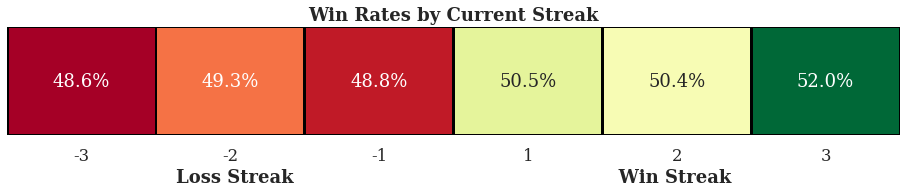

In [35]:
plt.rcParams['font.family'] = "serif"
plt.figure(figsize=(16,2))
lm = sns.heatmap([streak_wrs], cmap="RdYlGn", fmt=".1%", annot=True, xticklabels = streak_values , yticklabels = '', cbar= False, 
           linewidths=2, linecolor='black')
axes = lm.axes
axes.set_xlabel('Loss Streak                                                    Win Streak', fontweight = 'bold')
axes.set_title('Win Rates by Current Streak', fontweight = 'bold')

In [36]:
loss_streak = gold_df[gold_df['Streak'] < -1]
data_mean = loss_streak['Result'].mean()
adj = 0.476 / data_mean

In [37]:
cutoff1 = 800 # 12 mins
cutoff2 = 1800 # 30 mins

imm = loss_streak[loss_streak['Time Since Last Game'] < cutoff1]['Result'].mean()*adj
short = loss_streak[(loss_streak['Time Since Last Game'] >= cutoff1)&(loss_streak['Time Since Last Game'] < cutoff2)]['Result'].mean()*adj
long = loss_streak[loss_streak['Time Since Last Game'] >= cutoff2]['Result'].mean()*adj
avg_wr = loss_streak['Result'].mean()*adj

print("Mean win rate:", round(avg_wr, 2))
print("Immediate requeue:", round(imm, 2))
print("Short break:", round(short, 2))
print("Long break:", round(long, 2))

Mean win rate: 0.48
Immediate requeue: 0.47
Short break: 0.53
Long break: 0.48


Text(1.8, 47.8, 'Average Win Rate')

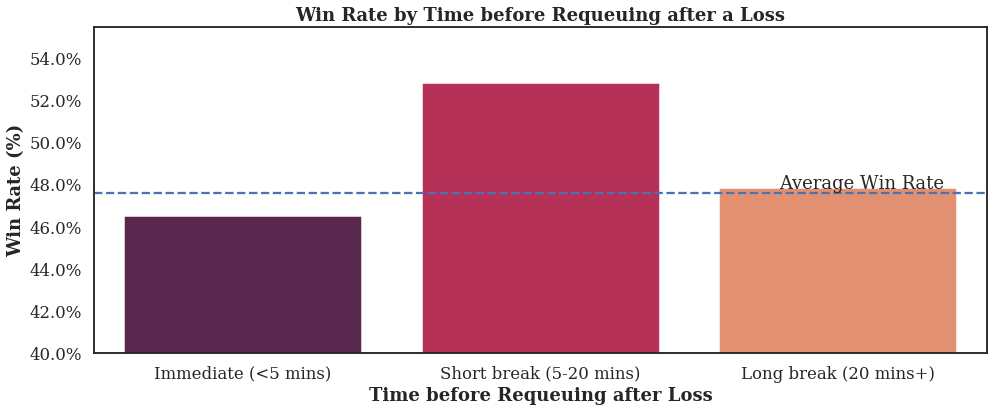

In [38]:
x = [imm, short, long]
x = [x * 100 for x in x]
y1 = ["Immediate (<5 mins)", "Short break (5-20 mins)", "Long break (20 mins+)"]

plt.figure(figsize=(16, 6))
lm = sns.barplot(x=y1, y=x, palette="rocket")
axes = lm.axes
axes.set_ylim(40,)
axes.set_title('Win Rate by Time before Requeuing after a Loss', fontweight = 'bold')
axes.set_ylabel('Win Rate (%)', fontweight = 'bold')
axes.set_xlabel('Time before Requeuing after Loss', fontweight = 'bold')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
axes.axhline(avg_wr*100, ls='--')
plt.text(1.8,avg_wr*100+.2,'Average Win Rate')

In [39]:
def find_imm_wr(clean_df, tier, cutoff1, cutoff2):
    tier_df = clean_df[clean_df['Tier'] == tier]
    tier_mean = tier_df['Result'].mean()
    adj = 0.5 / tier_mean
    tier_losers = tier_df[tier_df['Streak'] < -1]
    losers_wr = tier_losers['Result'].mean()*adj
    imm_wr = tier_losers[tier_losers['Time Since Last Game'] < cutoff1]['Result'].mean()*adj
    hour_wr = tier_losers[(tier_losers['Time Since Last Game']>= cutoff1)&(tier_losers['Time Since Last Game']<cutoff2)]['Result'].mean()*adj
    long_wr = tier_losers[tier_losers['Time Since Last Game'] >= cutoff2]['Result'].mean()*adj
    return imm_wr, hour_wr, long_wr, losers_wr

In [42]:
gold_imm_wr, gold_hour_wr, gold_long_wr, gold_losers_wr = find_imm_wr(clean_df, 'GOLD', cutoff1, cutoff2)
dia_imm_wr, dia_hour_wr, dia_long_wr, dia_losers_wr = find_imm_wr(clean_df, 'DIAMOND', cutoff1, cutoff2)

Text(1.8, 47.45018507665488, 'Average Win Rate')

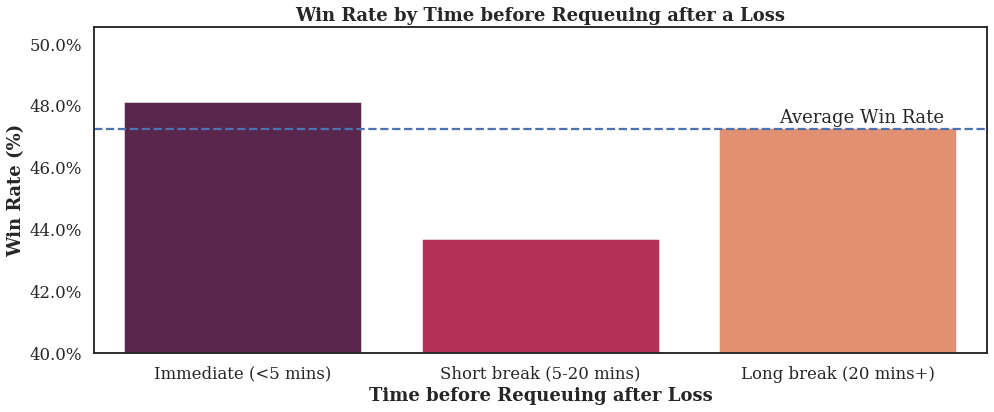

In [43]:
x = [dia_imm_wr, dia_hour_wr, dia_long_wr]
x = [x * 100 for x in x]
y1 = ["Immediate (<5 mins)", "Short break (5-20 mins)", "Long break (20 mins+)"]

plt.figure(figsize=(16, 6))
lm = sns.barplot(x=y1, y=x, palette="rocket")
axes = lm.axes
axes.set_ylim(40,)
axes.set_title('Win Rate by Time before Requeuing after a Loss', fontweight = 'bold')
axes.set_ylabel('Win Rate (%)', fontweight = 'bold')
axes.set_xlabel('Time before Requeuing after Loss', fontweight = 'bold')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
axes.axhline(dia_losers_wr*100, ls='--')
plt.text(1.8,(dia_losers_wr*100+.2),'Average Win Rate')